In [25]:
import numpy as np
import numpy.linalg as npla
import matplotlib.pyplot as plt
from matplotlib import animation


from sympy import exp, sin, cos, symbols
from sympy.utilities.lambdify import lambdify

np.set_printoptions(linewidth=np.inf)

In [26]:
# accuracy and range of x, y, and t
x_i, x_f = (0,np.pi)
y_i, y_f = (0,np.pi)
t_i, t_f = (0,1)

L_x = x_f - x_i
L_y = y_f - y_i

x_points = 20
y_points = 20
t_points = 100

# variables that will be used later
x_delta = (x_f - x_i) / (x_points - 1)
y_delta = (y_f - y_i) / (y_points - 1)
t_delta = (t_f - t_i) / (t_points - 1)

x = np.linspace(x_i, x_f, x_points)
y = np.linspace(y_i, y_f, y_points)
t = np.linspace(t_i, t_f, t_points)

nodes = x_points * y_points
nonboundary_nodes = (x_points - 2) * (y_points - 2)

# animation settings
duration = 5
animation_interval = 1000 * duration / t_points # t_points = frames
repeat_delay = 100000
cmap = 'Wistia'

redo_actual_data = False

In [27]:
# Navier-Stokes Equation
xv, yv = np.meshgrid(x, y)
x_symbol, y_symbol, t_symbol = symbols('x y t')

# dv/dt + R * (u * ∇) u = -∇p + μ∇^2u + f
# let U = [u, v] (or [u, v, w] in 3D)
# du/dt + R * (u du/dx + v du/dy) = -dp/dx + μ(d2u/dx2 + d2u/dy2) + f_u
# dv/dt + R * (u dv/dx + v dv/dy) = -dp/dy + μ(d2v/dx2 + d2v/dy2) + f_v
# (next line is only for 3d)
# dw/dt + R * (u dw/dx + v dw/dy + w dw/dz) = -dp/dz + μ(d2w/dx2 + d2w/dy2 + d2w/dz2) + f_w
# technically there should be a density term, but I'm going to assume the density is 1 for now

# constants
mu = .1
r = 1 # in the equation it is capital R, but I want to use that variable later

# intial conditions
ui = -cos(x_symbol) * sin(y_symbol)
vi = sin(x_symbol) * cos(x_symbol)
pi = -(cos(2 * x_symbol) + cos(2 * y_symbol)) / 4

ui = np.vectorize(lambdify([x_symbol, y_symbol], ui))
vi = np.vectorize(lambdify([x_symbol, y_symbol], vi))
pi = np.vectorize(lambdify([x_symbol, y_symbol], pi))

init_x = ui(xv, yv)
init_y = vi(xv, yv)
init_p = pi(xv, yv)

# forcing function
E_x = np.vectorize(lambdify([x_symbol, y_symbol, t_symbol], 0))
E_y = np.vectorize(lambdify([x_symbol, y_symbol, t_symbol], 0))

# boundary conditions
u_x_0 = 0
u_x_L = 0
u_y_0 = -sin(y_symbol) * exp(-2 * t_symbol)
u_y_L = sin(y_symbol) * exp(-2 * t_symbol)

v_y_0 = 0
v_y_L = 0
v_x_0 = sin(x_symbol) * exp(-2 * t_symbol)
v_x_L = -sin(x_symbol) * exp(-2 * t_symbol)

p_x_0 = -(cos(2 * x_symbol) * exp(-4 * t_symbol)) / 4
p_x_L = -(cos(2 * x_symbol) * exp(-4 * t_symbol)) / 4
p_y_0 = -(cos(2 * y_symbol) * exp(-4 * t_symbol)) / 4
p_y_L = -(cos(2 * y_symbol) * exp(-4 * t_symbol)) / 4

# convert the sympy expression objects into numpy vectorize objects so it works with the meshgrid
u_x_0 = np.vectorize(lambdify([x_symbol, t_symbol], u_x_0))
u_x_L = np.vectorize(lambdify([x_symbol, t_symbol], u_x_L))
u_y_0 = np.vectorize(lambdify([y_symbol, t_symbol], u_y_0))
u_y_L = np.vectorize(lambdify([y_symbol, t_symbol], u_y_L))

v_y_0 = np.vectorize(lambdify([y_symbol, t_symbol], v_y_0))
v_y_L = np.vectorize(lambdify([y_symbol, t_symbol], v_y_L))
v_x_0 = np.vectorize(lambdify([x_symbol, t_symbol], v_x_0))
v_x_L = np.vectorize(lambdify([x_symbol, t_symbol], v_x_L))

p_x_0 = np.vectorize(lambdify([x_symbol, t_symbol], p_x_0))
p_x_L = np.vectorize(lambdify([x_symbol, t_symbol], p_x_L))
p_y_0 = np.vectorize(lambdify([y_symbol, t_symbol], p_y_0))
p_y_L = np.vectorize(lambdify([y_symbol, t_symbol], p_y_L))

# accuracy controls for pressure evolution
l = float(x_delta ** 2 / (t_delta * sin(2 * x_delta)))
e = float(x_delta ** 3)

In [28]:
# code for generating animations

# creates the maginute scalar field from the x (u) and y (v) components
def velocity_magnitude_field(u, v):
    magnitude = lambda x, y : np.sqrt(x ** 2 + y ** 2)
    vfunc = np.vectorize(magnitude)

    return vfunc(u, v)

# assumes data has shape (t_points, x_points * y_points) 
def gen_anim(data, file_name):
    fig, ax = plt.subplots(1, 1, figsize = (6,6))

    max_z = data.min()
    min_z = data.max()
    
    print(f"max : {max_z}, min : {min_z}")

    def animate(i):
        ax.cla()

        curr_data = data[i].reshape((y_points, x_points))

        ax.pcolormesh(x, y, curr_data[:-1,:-1], cmap = plt.get_cmap(cmap), shading='flat')
        ax.set_xlim((x_i, x_f))
        ax.set_ylim((y_i, y_f))

    anim = animation.FuncAnimation(fig, animate, frames = t_points - 1, interval = animation_interval, blit = False, repeat = False)
    anim.save(file_name)

In [29]:
# actual solution

actual_u = -cos(x_symbol) * sin(y_symbol) * exp(-2 * t_symbol)
actual_v = sin(x_symbol) * cos(y_symbol) * exp(-2 * t_symbol)
actual_p = -.25 * (cos(2 * x_symbol) + cos(2 * y_symbol)) * exp(-4 * t_symbol)

actual_u = np.vectorize(lambdify([x_symbol, y_symbol, t_symbol], actual_u))
actual_v = np.vectorize(lambdify([x_symbol, y_symbol, t_symbol], actual_v))
actual_p = np.vectorize(lambdify([x_symbol, y_symbol, t_symbol], actual_p))

actual_u_mat = np.array([actual_u(xv, yv, curr_t).flatten() for curr_t in t])
actual_v_mat = np.array([actual_v(xv, yv, curr_t).flatten() for curr_t in t])
actual_p_mat = np.array([actual_p(xv, yv, curr_t).flatten() for curr_t in t])

print([curr_t for curr_t in t])
print([max(i) for i in actual_p_mat])

mag = velocity_magnitude_field(actual_u_mat, actual_v_mat)
actual_p = np.array(actual_p_mat)

if redo_actual_data:
    gen_anim(mag, "tmp/actual_mag_field.gif")
    gen_anim(actual_p, "tmp/actual_p_field.gif")

[0.0, 0.010101010101010102, 0.020202020202020204, 0.030303030303030304, 0.04040404040404041, 0.05050505050505051, 0.06060606060606061, 0.07070707070707072, 0.08080808080808081, 0.09090909090909091, 0.10101010101010102, 0.11111111111111112, 0.12121212121212122, 0.13131313131313133, 0.14141414141414144, 0.15151515151515152, 0.16161616161616163, 0.17171717171717174, 0.18181818181818182, 0.19191919191919193, 0.20202020202020204, 0.21212121212121213, 0.22222222222222224, 0.23232323232323235, 0.24242424242424243, 0.25252525252525254, 0.26262626262626265, 0.27272727272727276, 0.2828282828282829, 0.29292929292929293, 0.30303030303030304, 0.31313131313131315, 0.32323232323232326, 0.33333333333333337, 0.3434343434343435, 0.3535353535353536, 0.36363636363636365, 0.37373737373737376, 0.38383838383838387, 0.393939393939394, 0.4040404040404041, 0.4141414141414142, 0.42424242424242425, 0.43434343434343436, 0.4444444444444445, 0.4545454545454546, 0.4646464646464647, 0.4747474747474748, 0.4848484848484

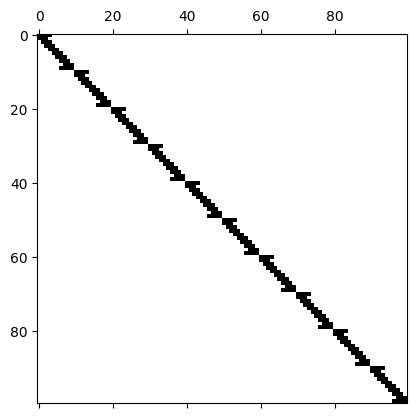

In [30]:
# Laplacian Matrix
fd_coeffs = {1 : [[-3/2, 2, -1/2], [-1/2, 0, 1/2], [1/2, -2, 3/2]], 2 : [[2, -5, 4, -1], [1, -2, 1], [-1, 4, -5, 2]]}
delta_powers = {1 : (1, 1, 1), 2: (3, 2, 3)}

def derivative_1d(points : int, delta : float, order = int):
    forward, central, backward = fd_coeffs[order]
    delta_power = delta_powers[order]

    mat = np.zeros((points, points))
    for i in range(1, points - 1): mat[i, i-1:i+ len(central) - 1] = [x / delta ** delta_power[1] for x in central]
    
    mat[0][0:len(forward)] = [x / delta ** delta_power[0] for x in forward]
    mat[-1][-len(backward):] = [x / delta ** delta_power[2] for x in backward]

    return mat

def derivative_2d(x_points : int, x_delta : float, y_points : int, y_delta : int, order = int):
    return np.kron(derivative_1d(y_points, y_delta, order), np.eye(x_points)) + np.kron(np.eye(y_points), derivative_1d(x_points, x_delta, order))

mat = np.kron(derivative_1d(10, 1/3, 2), np.eye(10)) # taking derivative with respect to x_2
other_mat = np.kron(np.eye(10), derivative_1d(10, 1/3, 2)) # taking derivative with respect to x_1

from matplotlib import pyplot as plt

plt.spy(mat)
plt.spy(other_mat)

In [31]:
# creating the evolution matrix
# let gen_mat(u_i) = A
# A * *u = u_i
def gen_mat(u_i, x_delta, order):
    # order = 0 -> u_n -> u* (pde in x)
    # order = 1 -> u* -> u** (pde in y)

    u_test = np.zeros((x_points * y_points, x_points * y_points))
    index = 0
    for i in u_i.flatten(): u_test[index] = i

    R = r * t_delta / (2 * x_delta)
    # T = t_delta * mu / (x_delta ** 2)
    T = t_delta / (x_delta ** 2)

    if order == 0:
        R_mat = np.kron(np.eye(y_points), R * derivative_1d(x_points, x_delta, 1))
        t_mat = np.kron(np.eye(y_points), np.eye(x_points) - T * derivative_1d(x_points, x_delta, 2))
    elif order == 1:
        R_mat = np.kron(R * derivative_1d(y_points, y_delta, 1), np.eye(x_points))
        t_mat = np.kron(np.eye(x_points) -T * derivative_1d(y_points, y_delta, 2), np.eye(x_points))

    return t_mat + R_mat * u_test

In [32]:
def bp(u, v, curr_t):
    # boundary conditions for u
    u[0:x_points] = u_y_0(x, curr_t)
    u[-x_points:] = u_y_L(x, curr_t)

    index = 0
    for x_val in u_x_0(y, curr_t):
        u[index] = x_val
        index += x_points

    index = x_points - 1
    for x_val in u_x_L(y, curr_t):
        u[index] = x_val
        index += x_points

    # boundary conditions for v
    v[0:x_points] = v_y_0(x, curr_t)
    v[-x_points:] = v_y_L(x, curr_t)

    index = 0
    for x_val in v_x_0(y, curr_t):
        v[index] = x_val
        index += x_points

    index = x_points - 1
    for x_val in v_x_L(y, curr_t):
        v[index] = x_val
        index += x_points

    return (u, v)

def p_bp(p, curr_t):
    p[0:x_points] = p_y_0(x, curr_t)
    p[-x_points:] = p_y_L(x, curr_t)

    index = 0
    for x_val in p_x_0(y, curr_t):
        p[index] = x_val
        index += x_points

    index = x_points - 1
    for x_val in p_x_L(y, curr_t):
        p[index] = x_val
        index += x_points

    return p

In [33]:
# restriction and prolongation matricies
P = np.zeros((nodes, nonboundary_nodes))
curr_index = 0
for i in range(nodes):
    if (i > x_points) and (i < nodes - x_points) and (i % x_points not in [0, x_points-1]):
        P[i, curr_index] = 1
        curr_index += 1

R = P.transpose()
print(P.shape)
print(R.shape)

(400, 324)
(324, 400)


In [34]:
# evolves u_i to u_aux
# shape of all input vectors should be (x_points * y_points, )
def gen_u_aux(u_i_x, u_i_y, curr_t):
    u_BC, v_BC = bp(np.zeros((y_points * x_points)), np.zeros((y_points * x_points)), curr_t)
    E_i_x = E_x(xv, yv, curr_t)
    E_i_y = E_y(xv, yv, curr_t)

    u_i_x = u_i_x.flatten()
    u_i_y = u_i_y.flatten()

    Ax_star = gen_mat(u_i_x, x_delta, 0)
    Ay_star = gen_mat(u_i_y, y_delta, 0)

    star_x = (P @ (npla.inv(R @ Ax_star @ P) @ (R @ (u_i_x - Ax_star @ u_BC)))) + u_BC
    star_y = (P @ (npla.inv(R @ Ay_star @ P) @ (R @ (u_i_y - Ay_star @ u_BC))))+ v_BC

    Ax_star = gen_mat(u_i_x, x_delta, 1)
    Ay_star = gen_mat(u_i_y, y_delta, 1)

    star_star_x = (P @ (npla.inv(R @ Ax_star @ P) @ (R @ ((star_x + t_delta * E_i_x.flatten()) - Ax_star @ u_BC)))) + u_BC
    star_star_y = (P @ (npla.inv(R @ Ay_star @ P) @ (R @ ((star_y + t_delta * E_i_y.flatten()) - Ay_star @ u_BC)))) + v_BC
 
    return (star_star_x.reshape(y_points, x_points), star_star_y.reshape(y_points, x_points))

def gen_u_aux_test(u, v, curr_t):
    E_ix = E_x(xv, yv, curr_t).flatten()
    E_iy = E_y(xv, yv, curr_t).flatten()

    u = u.flatten()
    v = v.flatten()


    x_deriv_1 = np.kron(np.eye(y_points), derivative_1d(x_points, x_delta, 1))
    y_deriv_1 = np.kron(derivative_1d(y_points, y_delta, 1), np.eye(x_points))

    x_deriv_2 = np.kron(np.eye(y_points), derivative_1d(x_points, x_delta, 2))
    y_deriv_2 = np.kron(derivative_1d(y_points, y_delta, 2), np.eye(x_points))

    print(u.shape)
    print(x_deriv_2.shape)
    Ax = np.eye(y_points * x_points) + r * t_delta * np.diag(u) @ x_deriv_1 - t_delta * x_deriv_2
    Ay = np.eye(y_points * x_points) + r * t_delta * np.diag(v) @ x_deriv_1 - t_delta * x_deriv_2 # is this right?

    u_star = npla.inv(Ax) @ u
    v_star = npla.inv(Ay) @ v

    Axx = np.eye(y_points * x_points) + r * t_delta * np.diag(v_star) * y_deriv_1 - t_delta * y_deriv_2
    Ayy = np.eye(y_points * x_points) + r * t_delta * np.diag(u_star) * y_deriv_1 - t_delta * y_deriv_2 # is this right?

    u_aux = np.reshape(npla.inv(Axx) @ (u_star + t_delta * E_ix), (y_points, x_points))
    v_aux = np.reshape(npla.inv(Ayy) @ (v_star + t_delta * E_iy), (y_points, x_points))

    return (np.reshape(u_aux, (y_points, x_points)), np.reshape(v_aux, (y_points, x_points))) # returns the matricies flattened'

u, v = gen_u_aux_test(init_x, init_y, 0)

print(u.max())
print(v.max())
print(u.min())
print(v.min())


(400,)
(400, 400)
1.011599897100036
0.47941855923620025
-1.011599897100036
-0.47941855923620014


In [35]:
# generate mat based on custom stencils
def custom_mat(stencils, points):
    forward_stencil, central_stencil, backward_stencil = stencils
    mat = np.zeros((points, points))
    mat[0, 0:len(forward_stencil)] = forward_stencil
    mat[-1, -len(backward_stencil):] = backward_stencil
    for i in range(1, y_points - 1): mat[i, i - 1: i + len(central_stencil) - 1] = central_stencil

    return mat

MovieWriter ffmpeg unavailable; using Pillow instead.


1.5398854861841824
6.15954194473673
(400,)
(400, 400)
1
49.29704389755511
-36.41353909905234
49.28690788212959
-35.979799661278086
2
3435.89963147234
-2726.354553910491
3386.6025875751716
-2689.941014811439
3
116402.11716461826
-226920.258059775
112966.21753314593
-224252.42411742258
4
526389.9038569268
-14161028.479518874
409987.78669230855
-13934108.221459098
5
-21787.362222185035
-717867281.285106
-21419.36916140721
-703706252.805587
6
-378006.85669823526
-31770481806.73149
-356219.49447605025
-31052614525.446384
7
-11125553.754294546
-1290030096596.7395
-10747546.89759631
-1260158435693.2668
8
-287449314.16847026
-51418441644513.14
-276323760.4141757
-50128411547916.4
9
-7856124712.265263
-1937603070020619.0
-7568675398.096792
-1886184628376105.8
10
-217338524085.8202
-7.0100946208353496e+16
-209482399373.55493
-6.816335179228482e+16
11
-6065129526036.871
-2.4906212271007964e+18
-5847791001951.051
-2.4217457717771694e+18
12
-171240057672544.06
-8.742208807242732e+19
-16517492814650

C:\Users\gauth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\tri\_triangulation.py:181: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)


IndexError: index 20 is out of bounds for axis 0 with size 20

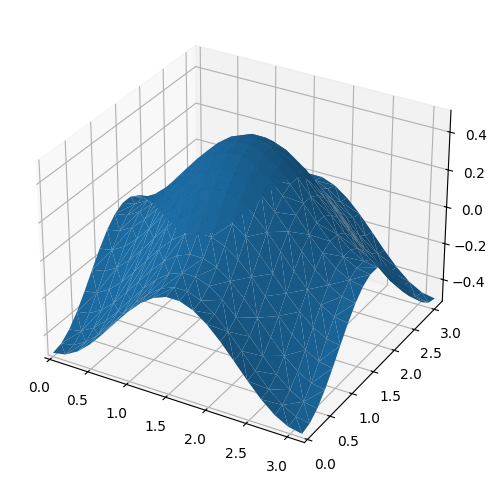

In [36]:
from copy import deepcopy

u = init_x
v = init_y
p = init_p

u_mat = np.zeros((t_points, x_points * y_points))
v_mat = np.zeros((t_points, x_points * y_points))
p_mat = np.zeros((t_points, x_points * y_points))

index = 0

x_range = list(range(x_points))
y_range = list(range(y_points))

delta_range = 20

delta_data = np.zeros((delta_range, x_points * y_points))

factor = .25 * t_delta * l * (1/(x_delta ** 2) + 1/(y_delta ** 2))
pseudofactor_x = l * t_delta * (1/(4 * x_delta ** 2) - 1/(16 * y_delta ** 2)) # =
pseudofactor_y = l * t_delta * (-1/(16 * x_delta ** 2) + 1/(4 * y_delta ** 2)) # ||

test_factor = l * t_delta * (1/(x_delta ** 2) + 1/(y_delta ** 2))

alpha_x = l * t_delta / (x_delta ** 2)
alpha_y = l * t_delta / (y_delta ** 2)

print(factor)
print(test_factor)

for curr_t in t[:-1]:
    u_aux, v_aux = gen_u_aux_test(u, v, curr_t)

    aux_factor_mat = np.kron(np.eye(y_points), derivative_1d(x_points, x_delta, 1)) @ u_aux.flatten() + np.kron(derivative_1d(x_points, x_delta, 1), np.eye(y_points)) @ v_aux.flatten()
    aux_factor_mat = np.reshape(aux_factor_mat, (20, 20))
    

    pThresh = False

    i = 0
    delta_data[i] = init_p.flatten()

    while not pThresh:
        old_p = deepcopy(p)
        
        for q in range(x_points):
            for r in range(y_points):
                factor = 0
                u = aux_factor_mat[q,r]

                x_complete = False
                y_complete = False

                # x boundary
                if q == 0:
                    factor = alpha_y
                    p_factor = 2 * alpha_x * (old_p[3, r] - (old_p[4, r] + old_p[2, r]) / 4)
                    x_complete = True
                if q == x_points - 1:
                    factor = alpha_y
                    p_factor = 2 * alpha_x * (old_p[-4, r] - old_p[-5, r] + old_p[-3, r] / 4)
                    x_complete = True

                # y boundary
                if r == 0 and not x_complete:
                    factor = alpha_x
                    p_factor = 2 * alpha_y * (old_p[q, 3] - (old_p[q, 4] + old_p[q, 2]) / 4)
                    y_complete = True
                if r == y_points - 1 and not x_complete:
                    factor = alpha_x
                    p_factor = 2 * alpha_y * (old_p[q, -4] - (old_p[q, -5] + old_p[q, -3]) / 4)
                    y_complete = True

                # x pseudoboundary
                if q == 1 and not y_complete:
                    factor += alpha_y / 2
                    p_factor += alpha_y * old_p[3, r]
                if q == x_points - 2 and not y_complete:
                    factor += alpha_y / 2
                    p_factor += alpha_y * old_p[-4, r]

                # y pseudoboundary
                if r == 1 and not x_complete:
                    factor += alpha_x / 2
                    p_factor += alpha_x * old_p[q, 3]
                if r == y_points - 2 and not x_complete:
                    factor += alpha_x / 2
                    p_factor += alpha_x * old_p[q, -4]

                # interior points
                if q in range(2, x_points - 2):
                    factor += alpha_y
                    p_factor += alpha_y * (old_p[q - 2, r] + old_p[q + 2, r])
                if r in range(2, y_points - 2):
                    factor += alpha_x
                    p_factor += alpha_x * (old_p[q, r - 2] + old_p[q, r + 2])

                p[q, r] = ((1 - factor) * old_p[q, r] - l * u + p_factor)

        print(i := i + 1)
        print(np.max(p))
        print(np.min(p))
        print(np.max(p - old_p)) # if this increases, p does not converge
        print(np.min(p - old_p))

        if np.max(p - old_p) <= e and np.min(p - old_p) >= -e: 
            pThresh = True

            # calc u and v here
            for curr_x in x_range[:-2]:
                for curr_y in y_range[1:-1]:
                    u[curr_y, curr_x + 1] = u_aux[curr_y, curr_x + 1] - t_delta / (2 * x_delta) * (old_p[curr_y, curr_x + 2] - .5 * (p[curr_y, curr_x] + old_p[curr_y, curr_x]))

            for curr_y in y_range[:-2]:
                for curr_x in x_range[1:-1]:
                    v[curr_y + 1, curr_x] = v_aux[curr_y + 1, curr_x] - t_delta / (2 * y_delta) * (old_p[curr_y + 2, curr_x] - .5 * (p[curr_y, curr_x] + old_p[curr_y, curr_y]))
        

        if i == delta_range:            
            mag = velocity_magnitude_field(u_mat, v_mat)

            # gen_anim(mag, 'tmp/velocity_field.gif')
            # gen_anim(p_mat, 'tmp/pressure_field.gif')
            delta_data.reshape((delta_range, x_points * y_points))

            fig, ax = plt.subplots(1, 1, figsize = (6,6), subplot_kw={"projection": "3d"})
            
            max_z = delta_data.max()
            min_z = delta_data.min()

            def animate(i):
                ax.cla()

                trisurf = ax.plot_trisurf(xv.flatten(), yv.flatten(), delta_data[i])
                ax.set_xlim((x_i, x_f))
                ax.set_ylim((y_i, y_f))
                # ax.set_zlim((min_z, max_z))
                
            anim = animation.FuncAnimation(fig, animate, frames = t_points - 1, interval = 1000, blit = False, repeat = False)
            anim.save("tmp/test2.gif")
            

            raise Exception("p does not converge")
        
        delta_data[i] = p.flatten()
        
        
    
    print(f"current time: {curr_t}")

    u_curr, v_curr = bp(u.flatten(), v.flatten(), curr_t)

    u_mat[index] = u_curr
    v_mat[index] = v_curr
    p_mat[index] = p.flatten()

    index += 1
    
mag = velocity_magnitude_field(u_mat, v_mat)

gen_anim(mag, 'tmp/velocity_field.gif')
gen_anim(p_mat, 'tmp/pressure_field.gif')